In [1]:
%matplotlib qt

import pandas as pd
import numpy as np
import mne
import os
import matplotlib.pyplot as plt
import scipy.io
from functools import reduce

In [2]:
CURRENT_PARTICIPANT = 'par_1'
EXPERIMENT_PART = 'part_3' 

if CURRENT_PARTICIPANT not in os.listdir(os.getcwd()):
    
    print('Participant folder not found')
    
    EEG_ANALYSIS_PARTICIPANT_FOLDER = os.path.join(os.getcwd(), CURRENT_PARTICIPANT)
    os.mkdir(EEG_ANALYSIS_PARTICIPANT_FOLDER)
    
    PARTICIPANT_MNE_RAW_PATH = os.path.join(EEG_ANALYSIS_PARTICIPANT_FOLDER, 'mne_raw')
    os.mkdir(PARTICIPANT_MNE_RAW_PATH)
    
else:
    print('Participant folder found!')
    EEG_ANALYSIS_PARTICIPANT_FOLDER = os.path.join(os.getcwd(), CURRENT_PARTICIPANT)
    PARTICIPANT_MNE_RAW_PATH = os.path.join(EEG_ANALYSIS_PARTICIPANT_FOLDER, 'mne_raw')

MAIN_DATA_FOLDER = os.path.abspath('../data')
os.chdir(MAIN_DATA_FOLDER)




Participant folder found!


In [3]:
# Loading participant data from .mat file
mat_file_path = os.path.join(MAIN_DATA_FOLDER, 
             f'{CURRENT_PARTICIPANT}\\eeg_data\\{EXPERIMENT_PART}.mat')

os.path.join(MAIN_DATA_FOLDER, 
             f'\\{CURRENT_PARTICIPANT}\\eeg_data\\{EXPERIMENT_PART}')

mat_file = scipy.io.loadmat(mat_file_path)
mat_data = mat_file['data']


# Putting the data onto a pd.DataFrame

mat_df = pd.DataFrame(mat_data)

# Making sure the columns [2:] are conatining just binary values
for columnName, columnData in mat_df.iteritems():
    mat_df.loc[mat_df[columnName] == 5.0, columnName] = 1.0
    mat_df.loc[mat_df[columnName] == -8.90625, columnName] = 0.0

mat_df.rename(columns = {
    0: 'PO3',
    1: 'PO4'
}, inplace= True)

# Converting the [2:] binary columns to a single 'event' column (stim channel)
binary_event_markers = mat_df.iloc[:, 2:]

def binary_to_decimal_events(pd_df: pd.DataFrame()):
    """
    Input - pd.DataFrame where each row is a vector representing a binary number
    Output - column with decimal numbers representing event marker
    """

    pd_df["combined_signal"] = [row for row in pd_df.to_numpy()]
    pd_df["combined_signal"] = pd_df["combined_signal"].apply(
        lambda x: x.astype(int)
    )  # Binary is in ints not floats
    event = (
        pd_df["combined_signal"]
        .apply(lambda x: np.flip(x))
        .apply(lambda x: reduce((lambda a, b: 2 * a + b), x))
    )

    return event

mat_df['event'] = binary_to_decimal_events(binary_event_markers)

# Removing the [2:] columns without the 'event' column (stim channel)
mat_df.drop([2, 3, 4, 5, 6, 7, 8, 9], axis= 1 , inplace= True)

# Converting DataFrame to ndarray and transposing it (it's mandatory for MNE)
eeg_data = mat_df.to_numpy().transpose()

# MNE Raw Setup and Epochs Setup
ch_names = ['PO3', 'PO4', 'stim_ch']
ch_types = ['eeg', 'eeg', 'stim']

info = mne.create_info(ch_names= ch_names,
                        ch_types= ch_types,
                        sfreq=1000)

raw = mne.io.RawArray(eeg_data, info)

event_markers = mne.find_events(raw= raw, stim_channel= 'stim_ch')
    

C:\Users\iPagera\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\iPagera\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Creating RawArray with float64 data, n_channels=3, n_times=720412
    Range : 0 ... 720411 =      0.000 ...   720.411 secs
Ready.
538 events found
Event IDs: [ 1  2  3  4 10 16 17 18 25]


In [4]:

def reshape_events(event_markers: list) -> dict:
    """ 
    Returns event markers list with correct event start timecode + event_id

    new_events = {
        'l_cue_l_tar': [],
        'l_cue_r_tar': [],
        'r_cue_l_tar': [],
        'r_cue_r_tar': []
    }

    'l_cue_l_tar' = 1;
    'l_cue_r_tar' = 2;
    'r_cue_l_tar' = 3;
    'r_cue_r_tar' = 4;

    Parameters:
    -----------

    event_markers: list - after calling mne.find_event markers on the mne.Raw object.
    """

    # Grouping each two consecutive events with the next one so to get
    # (0, 1), (1, 2), (2, 3) type of groupings in a list

    temp_list = []
    for previous, current in zip(event_markers, event_markers[1:]):
        temp_list.append((previous, current))

    
    # Creating new lists of events based on the first and second one of the groupings
    # If cue is left (=1) and tar is left (=3), 
    # new_event market -> 'l_cue_l_tar' , where timeCode= cueTimeCode and event = 1


    new_events = {'l_cue_l_tar': [],
            'l_cue_r_tar': [],
            'r_cue_l_tar': [],
            'r_cue_r_tar': []}


    for a, b in temp_list:
        if 1 in a and 3 in b:
            new_events['l_cue_l_tar'].append(list(a))
            # new_events['l_cue_l_tar'].append(list(b))
        elif 1 in a and 4 in b:
            new_events['l_cue_r_tar'].append(list(a))
            # new_events['l_cue_r_tar'].append(list(b))
        elif 2 in a and 3 in b:
            new_events['r_cue_l_tar'].append(list(a))
            # new_events['r_cue_l_tar'].append(list(b))
        elif 2 in a and 4 in b:
            new_events['r_cue_r_tar'].append(list(a))
            # new_events['r_cue_r_tar'].append(list(b))

    # Changing the event_id to match between the lists in a condition

    # Left Cue Right Target
    for i in new_events['l_cue_l_tar']:
        i[2] = 1

    # Left Cue Right Target
    for i in new_events['l_cue_r_tar']:
        i[2] = 2

    # Right Cue Left Target
    for i in new_events['r_cue_l_tar']:
        i[2] = 3
    
    # Right Cue Right Target
    for i in new_events['r_cue_r_tar']:
        i[2] = 4

    # Reducing the new_events dict onto a flat list
    ultimate_events = []
    for i in new_events:
        for elem in new_events[i]:
            ultimate_events.append(elem) # Important to make array into NumPy Object

    # Adding the START, STOP_BLOCK, START_LOFI, START_WHITE, START_SILENCE event markers
    for i in event_markers:
        if i[2] in [10, 18, 16, 17, 25]:
            ultimate_events.append(list(i))

    # Finally - important to sort the list of events based on time code 
    ultimate_events.sort(key= lambda x: x[0])
    return ultimate_events

In [5]:
ULTIMATE_EVENTS = reshape_events(event_markers)

In [6]:
EPOCHS = mne.Epochs(raw= raw,
                    events= ULTIMATE_EVENTS,
                    event_id= {
                        'leftCue/LeftTarget' : 1,
                        'leftCue/RightTarget': 2,
                        'rightCue/LeftTarget': 3,
                        'rightCue/RightTarget': 4,
                        'block/silence': 16,
                        'block/white': 17,
                        'block/lofi': 18,
                        'block/end':25
                    },
                   tmin= -0.2,
                   tmax= 1.7,
                    decim= 4
                   )


270 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


<ipython-input-6-21521162507b>:15: RuntimeWarning: The measurement information indicates a low-pass frequency of 500 Hz. The decim=4 parameter will result in a sampling frequency of 250 Hz, which can cause aliasing artifacts.
  decim= 4


### Sequencing of sound conditions

* lofi = 18
* white = 17
* silence = 16

#### Approximate locations
* first = EPOCHS[1:89]
* second = EPOCHS[91:179]
* third = EPOCHS[181:269]

Loading data for 88 events and 1901 original time points ...
0 bad epochs dropped
Loading data for 88 events and 1901 original time points ...
Loading data for 20 events and 1901 original time points ...


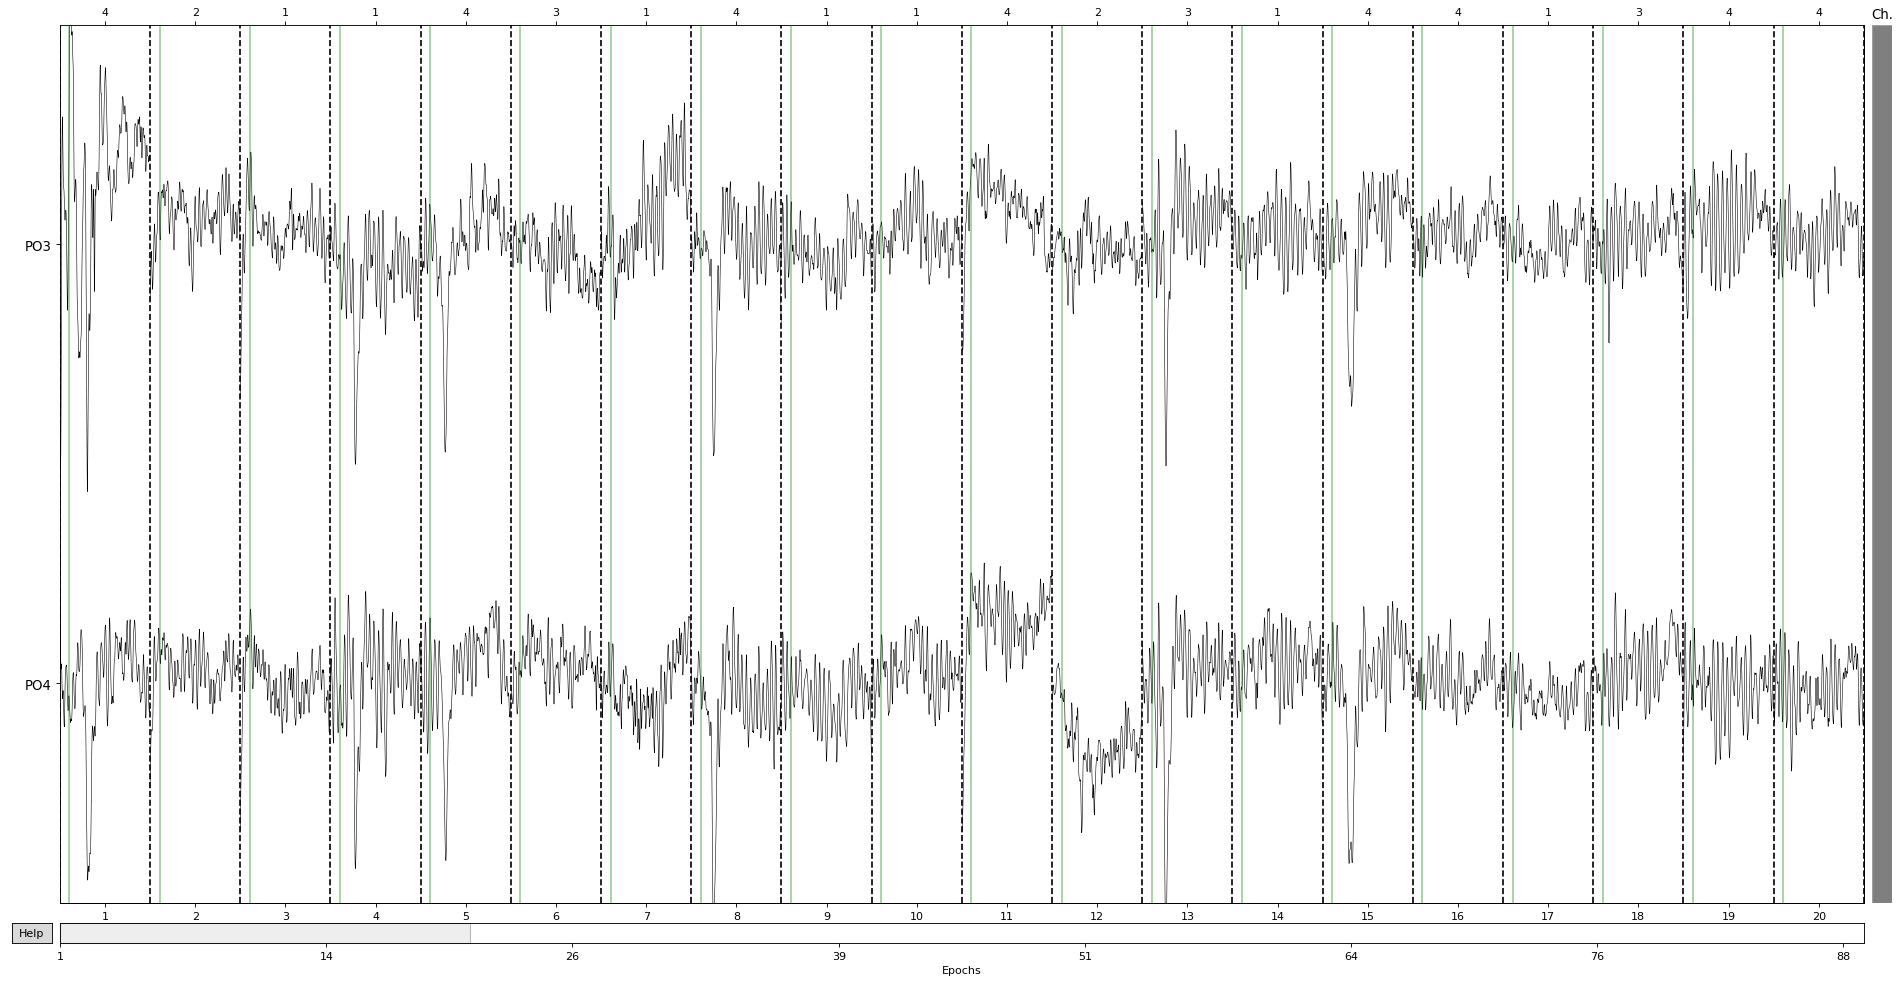

Loading data for 20 events and 1901 original time points ...
Loading data for 20 events and 1901 original time points ...
Loading data for 20 events and 1901 original time points ...


In [11]:
EPOCHS[181:269].plot(scalings= 15)

In [12]:
# Spread the epochs onto condition blocks

# Lofi = 18
lofi = EPOCHS[181:269]

# White = 17
white = EPOCHS[1:89]

# Silence = 16
silence = EPOCHS[91:179]

In [13]:
def save_raw_fifs(lofi, white, silence, part_of_exp= EXPERIMENT_PART, mne_raw_path= PARTICIPANT_MNE_RAW_PATH):
    """
    Saves sound condition blocks into .fif files in the individual participant's MNE RAW folder (see above)
    
    Parameters:
    -----------
    lofi: lofi epochs
    white: white epochs
    silence: silence epochs
    part_of_exp: int - EXPERIMENT_PART
    mne_raw_path: PARTICIPANT_MNE_RAW_PATH
    """
    
    lofi.save(f'{mne_raw_path}/lofi_{part_of_exp}.fif')
    silence.save(f'{mne_raw_path}/silence_{part_of_exp}.fif')
    white.save(f'{mne_raw_path}/white_{part_of_exp}.fif')

In [14]:
save_raw_fifs(lofi, white, silence)

Loading data for 88 events and 1901 original time points ...
0 bad epochs dropped
Loading data for 1 events and 1901 original time points ...
Loading data for 88 events and 1901 original time points ...
Loading data for 88 events and 1901 original time points ...
0 bad epochs dropped
Loading data for 1 events and 1901 original time points ...
Loading data for 88 events and 1901 original time points ...
Loading data for 88 events and 1901 original time points ...
0 bad epochs dropped


<ipython-input-13-88bd81043ad2>:14: RuntimeWarning: This filename (E:\Data Science and Coding\Python\Projects\Final Year Project Analysis\eeg_analysis\par_1\mne_raw/lofi_part_3.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  lofi.save(f'{mne_raw_path}/lofi_{part_of_exp}.fif')
<ipython-input-13-88bd81043ad2>:14: DeprecationWarning: overwrite defaults to True in 0.18 but will change to False in 0.19, set it explicitly to avoid this warning
  lofi.save(f'{mne_raw_path}/lofi_{part_of_exp}.fif')
<ipython-input-13-88bd81043ad2>:15: RuntimeWarning: This filename (E:\Data Science and Coding\Python\Projects\Final Year Project Analysis\eeg_analysis\par_1\mne_raw/silence_part_3.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  silence.save(f'{mne_raw_path}/silence_{part_of_exp}.fif')
<ipython-input-13-88bd81043ad2>:15: DeprecationWarni

Loading data for 1 events and 1901 original time points ...
Loading data for 88 events and 1901 original time points ...
Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []
